In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tushare as ts
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch.utils.data
from torch.utils.data import TensorDataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [67]:
class Config():
    data_path = r"data.csv"
    timestep = 20 # 时间步长，就是利用多少时间窗口
    batch_size = 256  # 批次大小
    feature_size = 1  # 每个步长对应的特征数量，这里只使用1维，每天的风速
    hidden_size = 512  # 隐层大小
    out_channels = 32 # CNN输出通道
    num_heads = 4 # 注意力机制头的数量
    output_size = 1  # 由于是单输出任务，最终输出层大小为1，预测未来1天径流
    num_layers = 4  # lstm的层数
    epochs = 50 # 迭代轮数

    learning_rate = 0.0003# 学习率
    model_name = 'cnn_lstm_attention' # 模型名称
    save_path = './{}.pth'.format(model_name + '_toy') # 最优模型保存路径
    weight_decay = 0.1 # 权重衰减
    
config = Config()



In [68]:
# 1.加载时间序列数据
df = pd.read_csv(config.data_path, index_col=0)
print(df.shape)
df

(26280, 7)


,load,year,month,hour,day,lowtmep,hightemp
date,,,,,,,
2016/11/25 0:00,193.987,0.0,0.909091,0.000000,0.666667,0.302326,0.243902
2016/11/25 1:00,187.120,0.0,0.909091,0.043478,0.666667,0.302326,0.243902
2016/11/25 2:00,189.514,0.0,0.909091,0.086957,0.666667,0.302326,0.243902
2016/11/25 3:00,190.690,0.0,0.909091,0.130435,0.666667,0.302326,0.243902
2016/11/25 4:00,206.349,0.0,0.909091,0.173913,0.666667,0.302326,0.243902
...,...,...,...,...,...,...,...
2019/11/24 19:00,305.301,1.0,0.909091,0.826087,1.000000,0.325581,0.390244
2019/11/24 20:00,293.212,1.0,0.909091,0.869565,1.000000,0.325581,0.390244
2019/11/24 21:00,286.829,1.0,0.909091,0.913043,1.000000,0.325581,0.390244


In [69]:
# 2.将数据进行标准化
scaler = StandardScaler()
scaler_model = StandardScaler()
data = scaler_model.fit_transform(np.array(df))
scaler.fit_transform(np.array(df['load']).reshape(-1, 1))

# 形成训练数据，例如12345789 12-3456789
def split_data(data, timestep, feature_size):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep):
        dataX.append(data[index: index + timestep][:, [0]])
        dataY.append(data[index + timestep][0])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.9 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, feature_size)
    y_train = dataY[: train_size].reshape(-1, 1)

    x_test = dataX[train_size:, :].reshape(-1, timestep, feature_size)
    y_test = dataY[train_size:].reshape(-1, 1)

    return [x_train, y_train, x_test, y_test]

In [70]:
# 3.获取训练数据   
x_train, y_train, x_test, y_test = split_data(data, config.timestep, config.feature_size)


In [71]:
# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)



In [72]:
print(x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape)

torch.Size([23634, 20, 1]) torch.Size([23634, 1]) torch.Size([2626, 20, 1]) torch.Size([2626, 1])


In [73]:
# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)


In [74]:
# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           config.batch_size,
                                           False)

test_loader = torch.utils.data.DataLoader(test_data,
                                          config.batch_size,
                                          False)



In [75]:
# 7.定义CNN + LSTM + Attention网络
class CNN_LSTM_Attention(nn.Module):
    def __init__(self, feature_size, timestep, hidden_size, num_layers, out_channels, num_heads, output_size):
        super(CNN_LSTM_Attention, self).__init__()
        self.hidden_size = hidden_size  # 隐层大小
        self.num_layers = num_layers  # lstm层数
        
        # 卷积层
        self.conv1d = nn.Conv1d(in_channels=feature_size, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv1d2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        
        # LSTM层
        # feature_size为特征维度，就是每个时间点对应的特征数量，这里为 4
        self.lstm = nn.LSTM(out_channels, hidden_size, num_layers, batch_first=True)
        
        # 注意力层
        self.attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
        
        # 输出层
        self.fc1 = nn.Linear(timestep * hidden_size, 256)
        self.fc2 = nn.Linear(256, output_size)
        
        # 激活函数
        self.relu = nn.ReLU()

    def forward(self, x, hidden=None):
        x = x.transpose(1, 2) # batch_size, feature_size, timestep[32, 4, 3]
        
        # 卷积运算
        output = self.conv1d(x)
        output = self.conv1d2(output)

        output = self.relu(output)
        
        batch_size = x.shape[0] # 获取批次大小
        
        # 初始化隐层状态
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
            c_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
        else:
            h_0, c_0 = hidden
        
        output = output.transpose(1, 2) # batch_size, feature_size, timestep[32, 1, 20]
        
        # 注意力计算
        output, self.attention.weight = self.attention(output, output, output)
        
        # output = self.relu(output)
        
        # LSTM运算
        output, (h_0, c_0) = self.lstm(output, (h_0, c_0)) # batch_size, timestep, hidden_size
        
        # 展开
        output = output.flatten(start_dim=1)
        
        # 全连接层
        output = self.fc1(output)
        output = self.relu(output)
        
        output = self.fc2(output)
        
        return output

model = CNN_LSTM_Attention(config.feature_size, config.timestep, config.hidden_size, config.num_layers, config.out_channels, config.num_heads, config.output_size)  # 定义CNN + LSTM + Attention网络
loss_function = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)  # 定义优化器
loss_function.to('cuda')


MSELoss()

In [76]:
# 检查是否有CUDA设备可用
if torch.cuda.is_available():
    device = torch.device("cuda")  # 将模型和数据转移到CUDA上
else:
    device = torch.device("cpu")  # 如果没有CUDA设备，则使用CPU

# 将模型和数据转移到相同的设备上
x_train, y_train, x_test, y_test = [data.to(device) 
                                    for data in [x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor]]

train epoch[50/50] train loss:0.11335465: 100%|██████████| 93/93 [00:02<00:00, 33.56it/s]


Finished Training
Test Loss: 0.09875910
Total loss: 0.10472264


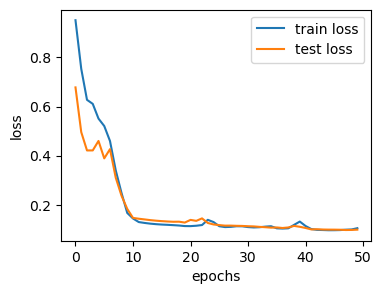

In [77]:

# 8.模型训练
model.to(device)
total_loss = 0
val_loss = 0
min_loss = 100
train_losses = []
val_losses = []
tolerance = 0
for epoch in range(config.epochs):
    model.train()

    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        x_train, y_train = data
        x_train = x_train.to(device)
        y_train = y_train.to(device)  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] train loss:{:.8f}".format(
            epoch + 1, config.epochs, loss
        )
        
    total_loss += running_loss / len(train_loader)

    train_losses.append(running_loss / len(train_loader))
    val_loss0 = 0
    model.eval()
    
    with torch.no_grad():
        for data in test_loader:
            x_val, y_val = data
            x_val = x_val.to(device)
            y_val = y_val.to(device)  # 解包迭代器中的X和Y
            y_val_pred = model(x_val)
            loss = loss_function(y_val_pred, y_val.reshape(-1, 1))
            val_loss0 += loss.item()

        val_loss0 = val_loss0 / len(test_loader)
        
        if val_loss0 > val_loss:
            tolerance += 1
        else:
            tolerance = 0
        if val_loss0 < min_loss:
            min_loss = val_loss0
             # 保存模型
            torch.save(model.state_dict(), config.save_path)
        val_loss = val_loss0

        # 检查是否满足早停条件
        if tolerance >= 5:
            print("early stopped at epoch[{}/{}] test loss:{:.8f}".format(epoch + 1, config.epochs, val_loss))
            break
    val_losses.append(val_loss)


print("Finished Training")
print("Test Loss: {:.8f}".format(val_losses[-1]))
print("Total loss: {:.8f}".format(train_losses[-1]))
# 绘制损失曲线
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

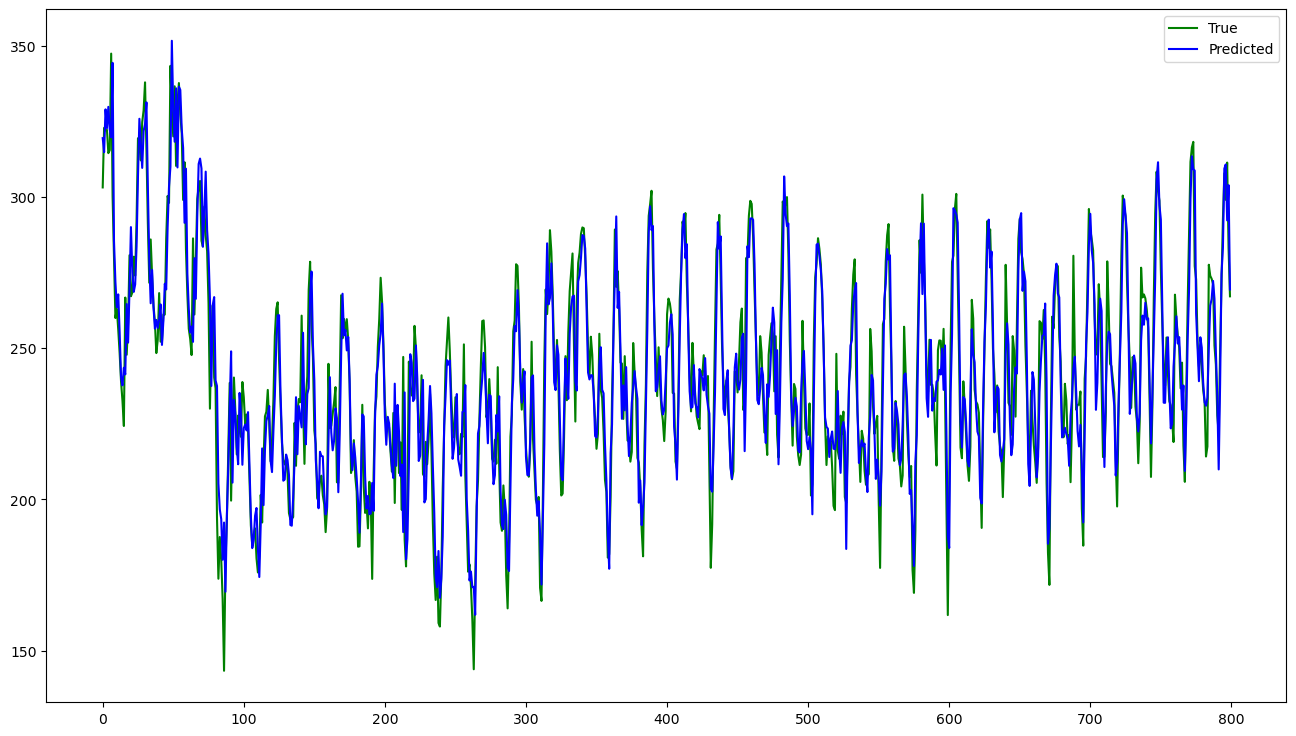

均方误差 (MSE): 59718.3046875
均方根误差 (RMSE): 244.373291015625
归一化的均方误差 (NME): 0.15579023957252502
归一化的均方根误差 (NRMSE): 0.3947027325630188
Test Loss: 0.09460851


In [78]:
model = CNN_LSTM_Attention(config.feature_size, 
                           config.timestep, 
                           config.hidden_size, 
                           config.num_layers, 
                           config.out_channels, 
                           config.num_heads, 
                           config.output_size)  # 定义CNN + LSTM + Attention网络
# 从.pth文件加载模型参数
model_path = 'cnn_lstm_attention_toy.pth'  # 模型路径
model_params = torch.load(model_path)
model.load_state_dict(model_params)


# 使用测试数据进行预测
model.to('cpu')
model.eval()
x_test_tensor.to('cpu')
y_test_pred = model(x_test_tensor)

# 绘制训练数据和预测结果
plot_size = 800
plt.figure(figsize=(16, 9))
plt.plot(scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1)[: plot_size]), "g", label="True")
plt.plot(scaler.inverse_transform(y_test_pred.detach().numpy().reshape(-1, 1)[: plot_size]), "b", label = "Predicted")
plt.legend()
plt.show()

# 将y_test_tensor从PyTorch张量转换为numpy数组
y_test_numpy = scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1))
# 计算MSE和RMSE
mse = mean_squared_error(y_test_numpy, y_test_pred.detach().numpy())
rmse = np.sqrt(mse)

print(f"均方误差 (MSE): {mse}")
print(f"均方根误差 (RMSE): {rmse}")

# 计算标准化的预测值和真实值
y_test_normalized = scaler.fit_transform(y_test_numpy)
y_pred_normalized = scaler.fit_transform(y_test_pred.detach().numpy())
# 计算MSE
nme = mean_squared_error(y_test_normalized, y_pred_normalized)

# 计算NRMSE
nrmse = np.sqrt(nme)

print(f"归一化的均方误差 (NME): {nme}")
print(f"归一化的均方根误差 (NRMSE): {nrmse}")

loss_function = nn.MSELoss()  # 定义损失函数
loss = loss_function(y_test_pred, y_test_tensor)
print("Test Loss: {:.8f}".format(loss.item()))
